# <u> Implementing the Perceptron Algorithm </u>

## Abstract

For this blog post I implemented the perceptron algorithm. I then ran several experiments to visualize the changes to my model each iteration and see the improvement of my loss. I investigated how the perceptron implementation changed when given linearly separable data vs not and 2 dimension vs more dimensional data. I also implemented mini-batch and ran experiments to see how this impacted algorithm outcomes. Through these steps, I learned the perceptron algorithm works and how that functionality can change to accommodate different data. Ultimately, I learned that the perceptron algorithm works well to address many different data forms by continuously updating the model based on misclassified points.

Link to source code ([perceptron.py](https://github.com/lfschweitzer/lfschweitzer.github.io/blob/8cd58f0ce43ca46d3514b1edf017020f1b33a4bc/posts/post4/perceptron.py))

In perceptron.py I implemented 5 functions: score, predict, loss, grad, and step. Here I will go through to briefly explain each function.

1. score:
Calculate the score by taking the cross product of the data input and the weights.

2. predict:
Calculates y_hat where y_hat is 1 when the score is greater than or equal to 0, and 0 otherwise.

3. loss:
Finds loss by calculating mean of misclassified data points.

4. grad:
Calculates score. If misclassified, returns gradient of cross product of data input and output $$\mathbb{1}\left[s_i y_{i} < 0 \right] y_{i} \mathbf{x}_{i}$$ Otherwise, return 0 gradient.

5. step:
Calls and returns loss function. Adds gradient from grad function to model.

In [103]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer
from perceptron_minibatch import Perceptron_mini, PerceptronOptimizer_mini

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Implement perceptron on linearly separable data

First, I used data from warmup to create a plot of linearly separable data.

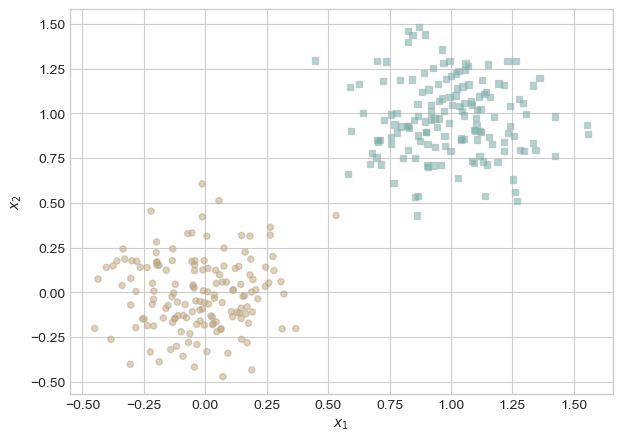

In [104]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

def plot_perceptron_data(X, y, ax):
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

See if perceptron.py code is functional by run the “minimal training loop” code from this section of the notes and eventually achieve loss = 0 on linearly separable data.

In [105]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)

    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]

    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

Then I showed visualizations of the data, the separating line, and the evolution of the loss function during training.

I copied the graph from notes in class to show the change of the loss in iterations of the perceptron algorithm.

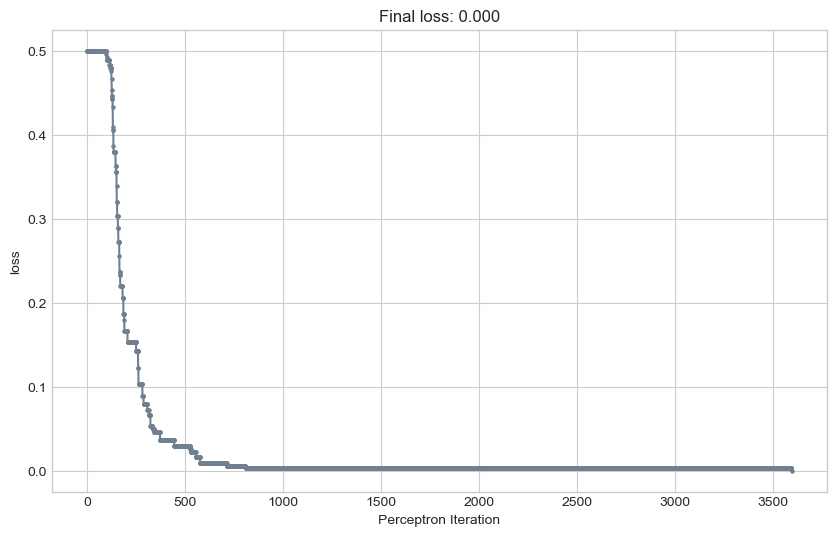

In [106]:
def plot_loss(loss):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))


    plt.plot(loss, color = "slategrey")
    plt.scatter(torch.arange(len(loss)), loss, color = "slategrey", s=5)
    labs = plt.gca().set(xlabel = "Perceptron Iteration", ylabel = "loss")
    
    plt.title(f"Final loss: {loss[len(loss)-1]:.3f}")


plot_loss(loss_vec)

This shows that the loss gradually decreases over the iterations and eventually reaches 0 (possible as the data is linearly separable).

We can then measure the accuracy of our predictions.

In [107]:
def find_accuracy(X, y):

    predictions = p.predict(X)
    
    # convert predictions from {0, 1} to {-1, 1}
    predictions = 2*predictions - 1
    
    correct_preds = (predictions == y).float()
    accuracy = torch.mean(correct_preds)

    print(f"Accuracy: {accuracy.item()}")

find_accuracy(X, y)

Accuracy: 1.0


Our model has perfect accuracy.

## Implement perceptron on data that is not linearly separable

I changed class notes code to include 50 points that overlap the existing classes. This will mean that the data is not necessarily linearly separable like the data before.

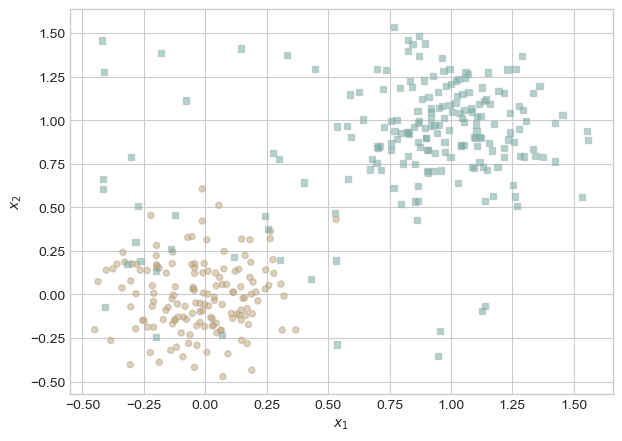

In [108]:
import torch
from matplotlib import pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
torch.manual_seed(1234)

def perceptron_data_overlap(n_points=300, noise=0.2, p_dims=2, overlap_points=50):
   
    y = torch.arange(n_points) >= int(n_points / 2)
    X = y[:, None] + torch.normal(0.0, noise, size=(n_points, p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # Add overlapping points within the range of existing points
    overlap_X = torch.rand(overlap_points, p_dims) * (X.max() - X.min()) + X.min()
    overlap_X = torch.cat((overlap_X, torch.ones((overlap_X.shape[0], 1))), 1)
    X = torch.cat((X, overlap_X), dim=0)

    # Convert y from {0, 1} to {-1, 1}
    y = torch.cat((2 * y - 1, torch.ones(overlap_points, dtype=torch.long)))  # Label the overlapping points as class 1

    return X, y

def plot_perceptron_data_overlap(X, y, ax):
    targets = [-1, 1]
    markers = ["o", ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix, 0], X[ix, 1], s=20, c=y[ix], facecolors="none", edgecolors="darkgrey", cmap="BrBG", vmin=-2, vmax=2, alpha=0.5, marker=markers[i])
    ax.set(xlabel=r"$x_1$", ylabel=r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data_overlap()
plot_perceptron_data_overlap(X, y, ax)
plt.show()

Next, I reran the perceptron algorithm. The difference with not linearly separable data is that I cannot run the algorithm until the loss is 0 as it will never be 0 for this data. Instead, I ran the data for 1000 iterations based on Pr.Chodrow's advice in the blog post description. I also including code to visualize model updates.

In [109]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
X, y = perceptron_data_overlap()

# initialize for main loop
loss_vec = []

for index in range(0, 1000):
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]

    # make an optimization step -- this is where the update actually happens
    local_loss = opt.step(x_i, y_i)

    # also add the new loss to loss_vec for plotting below
    loss = p.loss(X, y).item()
    loss_vec.append(loss)

I then reran code to show the updates of the loss.

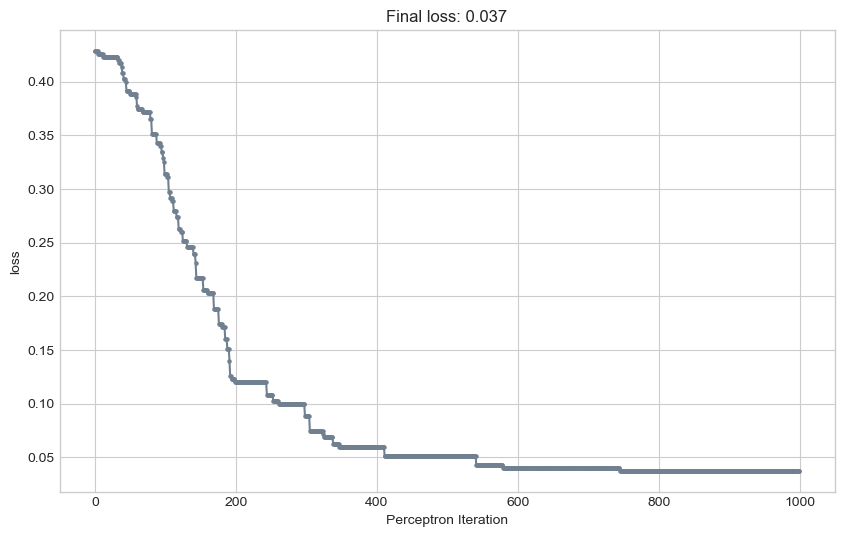

In [110]:
plot_loss(loss_vec)

Here we can see that the loss decreases over time but does not reach 0 like in the linearly separable case.

In [111]:
find_accuracy(X, y)

Accuracy: 0.9628571271896362


Close, but not perfect, accuracy.

## Implement perceptron on data with more than 2 dimensions

The only difference here is that I created data with more than 5 dimensions.

In [116]:
X, y = perceptron_data_overlap(n_points = 300, noise = 0.2, p_dims = 5)

I ran the perceptron algorithm for 1000 iterations, without knowing if the data is linearly separable.

In [117]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec_dimen = []

n = X.size()[0]

for index in range(0, 1000):
    
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]

    # perform a perceptron update using the random data point
    local_loss = opt.step(x_i, y_i)
    
    if (local_loss > 0):

        loss = p.loss(X, y).item()
        loss_vec_dimen.append(loss)
        

I then visualized the loss over time.

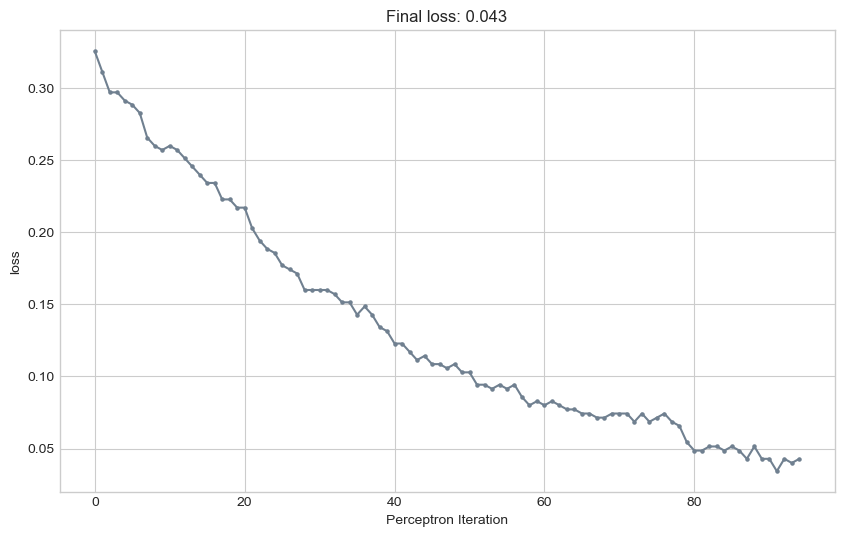

In [118]:
plot_loss(loss_vec_dimen)

Because the visualization of the loss vector shows that data never fully reaches a loss of 0 after 1000 iterations, we can conclude that the data is probably not linearly separable. 

In [119]:
find_accuracy(X, y)

Accuracy: 0.9571428298950195


Close, but not perfect, accuracy with non-linearly separable data.

## Implement Minibatch

I then modified my perceptron.grad() method so that it accepts a submatrix of the feature matrix X of size k*p. I changed the code from:

def grad(self, X, y):
        # should correctly return the “update” part of the perceptron update
        
        s = self.score(X)

       # if misclassified, calculate update
        if s*y <= 0:            
            update_val = X*y
            return update_val[0,:]
        else:
            return torch.zeros_like(self.w)

to

def grad(self, X, y):
        # should correctly return the “update” part of the perceptron update
        
        s = self.score(X)
        
        # choose random learning rate
        learning_rate = 0.3

        # if misclassified, calculate update
        misclass = s*y <= 0
        update_val_row = X*y[:,None]
        
        update_val = update_val_row * misclass[:,None]
        
        r = learning_rate * torch.mean(update_val, 0)
        
        return r

This change allowed the grad function to accept submatrices of the feature matrix X instead of just a single point.

## Minibatch Perceptron Experiments

I then performed experiments and create visualizations to demonstrate the following:

For linearly separable data, when k = 1, mini-batch perceptron performs similarly to regular perceptron.

In [120]:
X, y = perceptron_data()

In [121]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec_mini = []

n = X.size()[0]

while loss > 0:
    
    # K is 1
    k = 1
    
    # get a random submatrix of the feature matrix X and target vector y to implement minibatch
    ix = torch.randperm(X.size(0))[:k]
    x_i = X[ix,:]
    y_i = y[ix]
    
    opt.step(x_i, y_i)
    
    loss = p.loss(X, y).item()
    loss_vec_mini.append(loss)

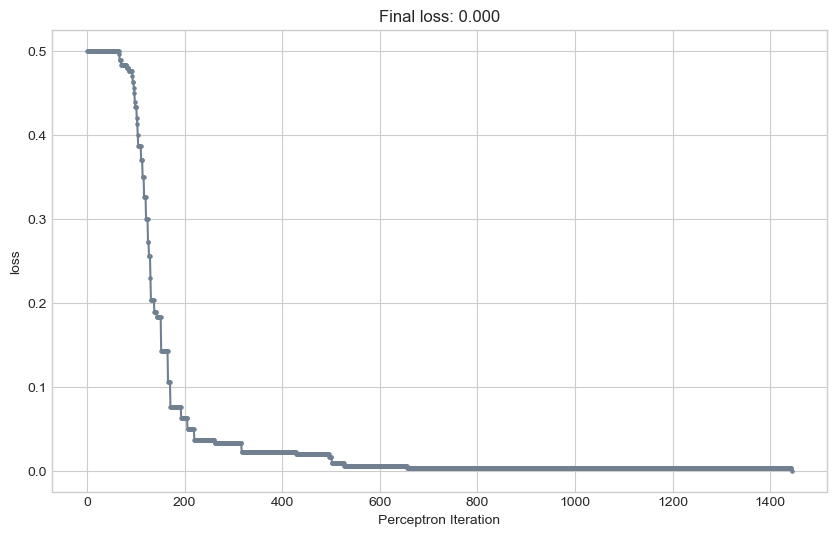

In [122]:
plot_loss(loss_vec_mini)

Loss goes to 0 after many iterations. And accuracy is perfect.

In [123]:
find_accuracy(X, y)

Accuracy: 1.0


Still with k=1, the perceptron with mini-batch performs similarly to the normal perceptron with overlapping data.

In [124]:
X, y = perceptron_data_overlap()

In [125]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)

# for keeping track of loss values
loss_vec_mini = []

for index in range(0, 1500):
    
    # K is 1
    k = 1
    
    # get a random submatrix of the feature matrix X and target vector y to implement minibatch
    ix = torch.randperm(X.size(0))[:k]
    x_i = X[ix,:]
    y_i = y[ix]
    
    opt.step(x_i, y_i)
    
    loss = p.loss(X, y).item()
    loss_vec_mini.append(loss)

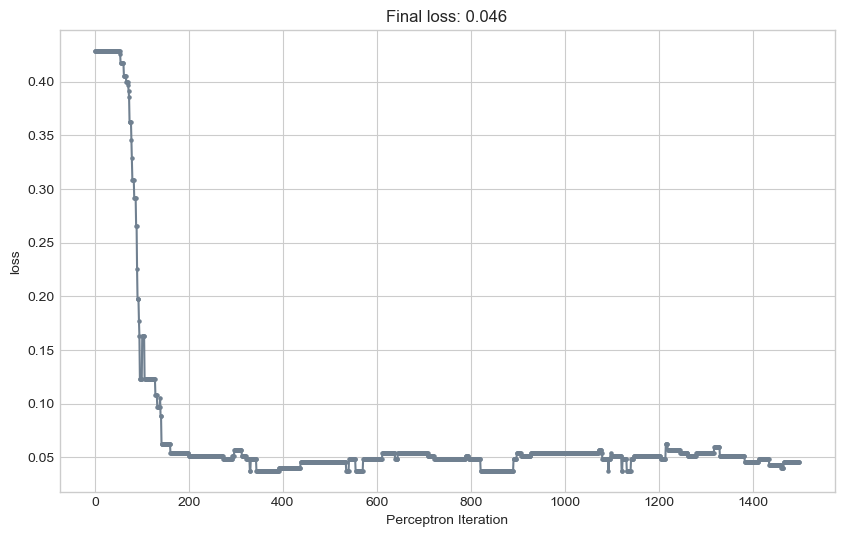

In [126]:
plot_loss(loss_vec_mini)

We can see that the perceptron reaches a loss close to, but never equal to, zero. We also have nearly perfect accuracy.

In [127]:
find_accuracy(X, y)

Accuracy: 0.954285740852356


For linearly separable data when k = 10, mini-batch perceptron can still find a separating line in 2d.

In [128]:
X, y = perceptron_data()

In [129]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec_mini = []

while loss > 0:
    
    # K is 10
    k = 10
    
    # get a random submatrix of the feature matrix X and target vector y to implement mini-batch
    ix = torch.randperm(X.size(0))[:k]
    x_i = X[ix,:]
    y_i = y[ix]
    
    opt.step(x_i, y_i)
    
    loss = p.loss(X, y).item()
    loss_vec_mini.append(loss)

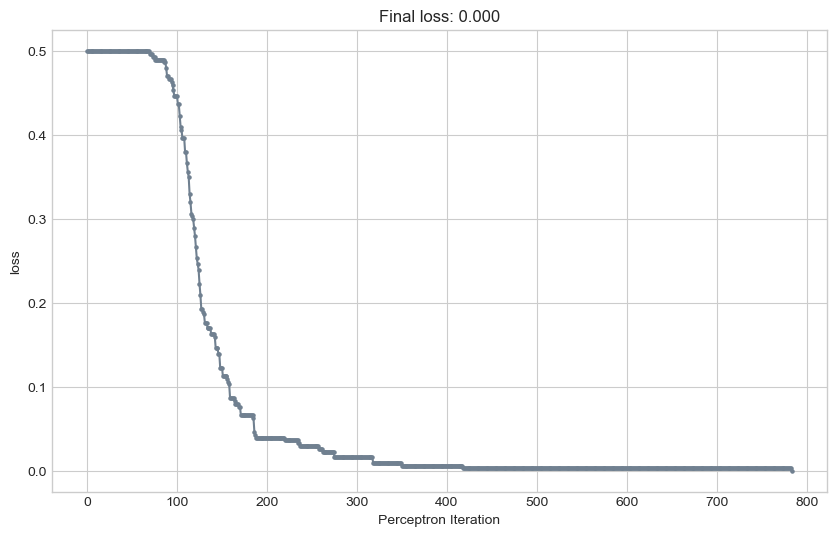

In [130]:
plot_loss(loss_vec_mini)

Here the loss reaches zero with linearly separable data. We also have 100% accuracy.

In [131]:
find_accuracy(X, y)

Accuracy: 1.0


When k = n (that is, the batch size is the size of the entire data set), mini-batch perceptron can converge even when the data is not linearly separable, provided that the learning rate is small enough.

In [132]:
X, y = perceptron_data_overlap()

In [133]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)

# for keeping track of loss values
loss_vec_mini = []

n = X.size()[0]

for index in range(0, 1000):
    
    # K is n
    k = n
    
    # get a random submatrix of the feature matrix X and target vector y to implement mini-batch
    ix = torch.randperm(X.size(0))[:k]
    x_i = X[ix,:]
    y_i = y[ix]
    
    opt.step(x_i, y_i)
    
    loss = p.loss(X, y).item()
    loss_vec_mini.append(loss)

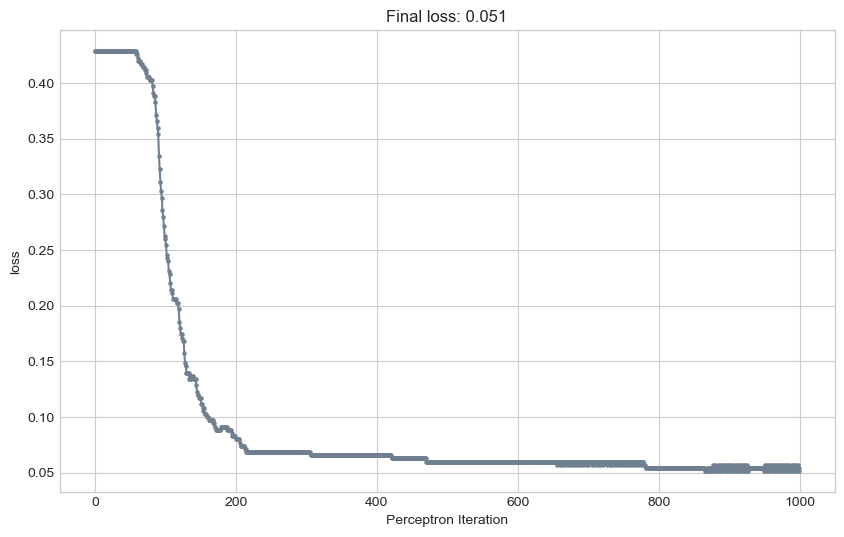

In [134]:
plot_loss(loss_vec_mini)

Even with overlapping data (not linearly separable) the algorithm converges with k=n at very close to 0 loss. Close to perfect accuracy.

In [135]:
find_accuracy(X, y)

Accuracy: 0.9485714435577393


## Discussion Question

### What is the runtime complexity of a single iteration of the perceptron algorithm? Does the runtime complexity of a single iteration depend on the number of data points n? What about the number of features p?

For a single iteration of the perceptron algorithm the dot product is taken between w and one row of the feature matrix X, as each row represents a data point. The size of the row of the feature matrix is p, the number of dimensions of the data. Therefore a single iteration's runtime is O(p). 

### If you implemented minibatch perceptron, what is the runtime complexity of a single iteration of the minibatch perceptron algorithm?

With the mini-batch algorithm, we take the dot product between each data point in the batch instead of just one for each iteration. Therefore it is O(kp) for each algorithm iteration.

## Conclusion

Through this blog post, I learned many important lessons in Machine Learning and computing in general. Firstly, I was able to implement the perceptron algorithm and understand the steps that go into updating a machine learning model. Through my experiments, I validates that my implementation were correct. I learned how to analyze the updates of perceptron and see how the algorithm functions on different data. I developed my abilities to visualize data and use those visualizations to understand both the input data and the algorithm itself. Ultimately, I was able to successfully implement and use the perceptron algorithm for linearly separable data, non-linearly separable data, and data with more than 2 dimensions. With mini-batch, I was able to demonstrate the algorithm functioned similarly to a single point with k=1, can still find a separating line in linearly separable data with k=10, and when k=n converge even without linearly separable data. 